In [1]:
# TODO: correct the calculation and drop the DPMM part
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
from math import sqrt
from numba import njit, float64
from numba.experimental import jitclass
from ing_theme_matplotlib import mpl_style

mpl_style(True)

In [2]:
spec = [
    ("P", float64),
    ("L", float64),
]

In [3]:
@njit
def AM(a, b):
    """
    arithmetic mean
    """
    return (a + b) / 2


@njit
def GM(a, b):
    """
    geometric mean
    """
    return sqrt(a * b)

In [4]:
@jitclass(spec)
class CPMM:
    def __init__(self, l=10_000.0, p=2500.0):
        """Constructor, instantiates a new AMM pool
        Args:
            p (float, optional): Price of token X (eg ETH) in token Y (eg USDT). Defaults to 2500.0.
            L (_type_, optional): Liquidity in pool, which is sqrt(reserveX * reserveY). Defaults to 10_000.0.
        """
        self.L = l
        self.P = p

    def xReserves(self):
        """Gets reserves of X (base) token from the pool.

        The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

        Returns:
            float: Reserves of X
        """
        return self.L / sqrt(self.P)

    def yReserves(self):
        """Gets reserves of Y (quote) token from the pool.

        The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

        Returns:
            float: Reserves of Y
        """
        return self.L * sqrt(self.P)

    def tradeToPrice(self, targetP):
        newL = self.L
        newP = targetP

        delta_x = newL / sqrt(newP) - self.L / sqrt(self.P)
        delta_y = newL * sqrt(newP) - self.L * sqrt(self.P)

        self.L = newL
        self.P = newP

        return (delta_x, delta_y)

In [5]:
@jitclass(spec)
class FMAMM:
    def __init__(self, l=10_000.0, p=2500.0):
        """Constructor, instantiates a new AMM pool
        Args:
            p (float, optional): Price of token X (eg ETH) in token Y (eg USDT). Defaults to 2500.0.
            L (_type_, optional): Liquidity in pool, which is sqrt(reserveX * reserveY). Defaults to 10_000.0.
        """
        self.L = l
        self.P = p

    def xReserves(self):
        """Gets reserves of X (base) token from the pool.

        The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

        Returns:
            float: Reserves of X
        """
        return self.L / sqrt(self.P)

    def yReserves(self):
        """Gets reserves of Y (quote) token from the pool.

        The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

        Returns:
            float: Reserves of Y
        """
        return self.L * sqrt(self.P)

    def tradeToPrice(self, targetP):
        newL = self.L * AM(self.P, targetP) / GM(self.P, targetP)
        newP = targetP

        delta_x = newL / sqrt(newP) - self.L / sqrt(self.P)
        delta_y = newL * sqrt(newP) - self.L * sqrt(self.P)

        self.L = newL
        self.P = newP

        return (delta_x, delta_y)

In [6]:
@njit
def run_simulations(
    daily_std,
    blocks_per_day,
    paths,
    days=1,
):
    # lvr for CPMM and FMAMM with 1 and 2 arbitrageurs, respectively
    results = np.zeros((6, paths))

    for jj in range(paths):
        amm0 = CPMM(10_000.0, 2500.0)
        amm1 = FMAMM(10_000.0, 2500.0)
        amm2 = FMAMM(10_000.0, 2500.0)

        # save the initial price
        p0 = amm0.P

        sigma = daily_std / np.sqrt(blocks_per_day)  # vol between blocks
        T = int(days * blocks_per_day)

        # Generate a GBM path for prices
        z = np.cumsum(np.random.normal(0.0, sigma, T))
        # Note that we are adding a risk-neutral drift, so that the price process is a martingale
        prices = np.exp(z - (np.arange(T) * sigma**2) / 2)
        prices = prices / prices[0] * p0

        lvr0 = 0.0
        lvr1 = 0.0
        lvr2 = 0.0

        for i in range(T):
            # on CPMM arbitrageurs report the external price honestly
            val0 = prices[i] * amm0.xReserves() + amm0.yReserves()
            x0, y0 = amm0.tradeToPrice(prices[i])
            lvr0 += -(prices[i] * x0 + y0) / val0

            # on FMAMM with 1 arbitrageur the profit is maximized by reporting the geometric mean
            val1 = prices[i] * amm1.xReserves() + amm1.yReserves()
            x1, y1 = amm1.tradeToPrice(GM(prices[i], amm1.P))
            lvr1 += -(prices[i] * x1 + y1) / val1

            # on FMAMM with 2 arbitrageurs the reported price will be P^{\frac{3}{4}} P^{\frac{1}{4}}_amm,
            # since the first will report geometric mean
            # and the second will report the geometric mean of external price and the first's report
            val2 = prices[i] * amm2.xReserves() + amm2.yReserves()
            x2, y2 = amm2.tradeToPrice(GM(prices[i], GM(prices[i], amm2.P)))
            lvr2 += -(prices[i] * x2 + y2) / val2

        results[:, jj] = [
            lvr0 / days,
            lvr1 / days,
            lvr2 / days,
            prices[T - 1] * amm0.xReserves() + amm0.yReserves(),
            prices[T - 1] * amm1.xReserves() + amm1.yReserves(),
            prices[T - 1] * amm2.xReserves() + amm2.yReserves(),
        ]

    return results

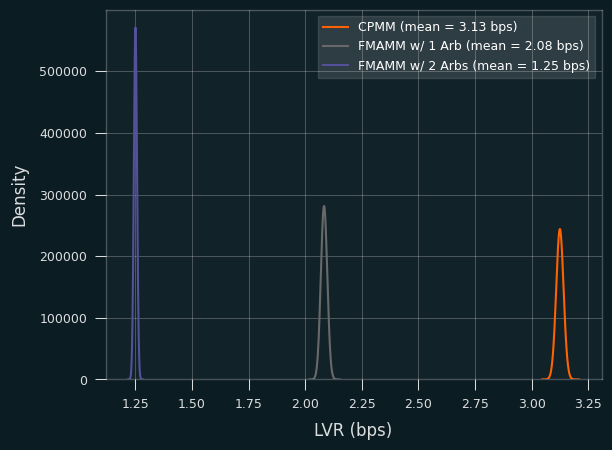

In [7]:
daily_std = 0.05
block_time = 5  # 12 for Mainnet, 5 for Gnosis, 1 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 10_000
days = 7

results = run_simulations(daily_std, blocks_per_day, paths, days)

# sns.set_style("darkgrid")
# sns.set_palette("autumn")

bw_adjust = 5
means = np.mean(results, 1)

# Plotting with the specified adjustments
ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM w/ 1 Arb (mean = {means[1] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM w/ 2 Arbs (mean = {means[2] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick * 10000) for tick in ticks_loc])

plt.legend()
plt.show()

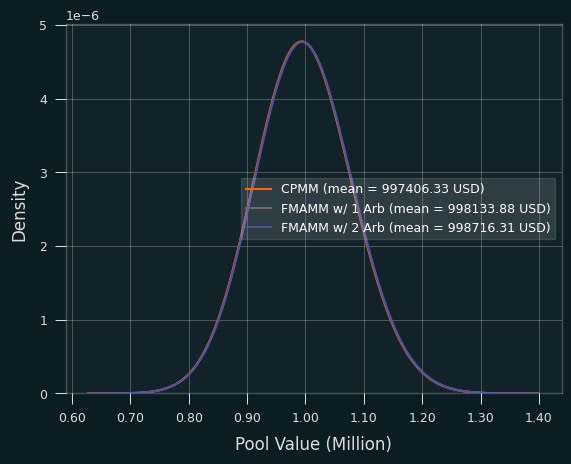

In [8]:
# Plotting with the specified adjustments
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[3]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[4, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM w/ 1 Arb (mean = {means[4]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[5, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM w/ 2 Arb (mean = {means[5]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()